In [1]:
import numpy as np
import pandas as pd
import pyampute
from pyampute.ampute import MultivariateAmputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import BayesianRidge
import os
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

# ivanovo_dataset with deleted  missing values 

In [2]:
X_full = np.genfromtxt(os.path.basename('/Desktop/GIT/Imputations/data_ivanovo.csv') , delimiter=';', skip_header=2)
#colnames = ['discr_1', 'discr_2', 'discr_3', 'discr_4', 'discr_5', 'discr_6', 'cont_1', 'cont_2', 'cont_3', 'cont_4', 'cont_5', 'cont_6', 'cont_7', 'cont_8', 'cont_9', 'cont_10', 'cont_11', 'cont_12'] 
cont_colnames = ['cont_1', 'cont_2', 'cont_3', 'cont_4', 'cont_5', 'cont_6', 'cont_7', 'cont_8', 'cont_9', 'cont_10', 'cont_11', 'cont_12'] 


df = pd.DataFrame(X_full)
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
#df.dropna() 1883/1858
#df

In [3]:
df_cont = df.iloc[:, 6:18]
df_cont.columns = [str(i) for i in range(df_cont.shape[1])]
df_cont

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.681272,0.839077,1.699830,0.780747,1.965416,2.297007,-0.619881,-0.906753,1.710877,1.080780,0.195906,-0.762807
1,1.465668,1.619690,1.556676,2.193946,1.396400,-0.673438,1.092172,-0.193068,0.172220,0.592126,1.120988,0.020496
2,-1.584760,-0.790098,-1.020090,-0.475431,-1.069334,-1.267527,-1.400506,-1.412281,-0.606606,-2.146019,0.000772,1.699002
3,1.117047,1.467215,1.914561,1.304154,1.111892,0.910800,0.045425,0.936935,0.020254,-0.022903,0.058590,-0.091404
4,0.506962,2.299204,1.771407,0.519043,0.732548,-0.574423,1.730865,-1.114912,0.789582,1.266131,-0.136545,1.251401
...,...,...,...,...,...,...,...,...,...,...,...,...
1878,-0.887519,-0.280463,0.339870,-0.789475,-0.595155,-0.178363,0.453479,-0.490437,-0.331168,0.137173,-0.273861,0.468098
1879,-0.713209,-0.280463,-0.053802,-0.946497,-1.164170,-1.366541,0.151873,1.501937,-0.141210,0.389925,-0.729175,0.132397
1880,-0.364589,0.414796,-0.018014,-0.266068,-0.215811,-1.366541,-0.398112,-1.560966,-0.036733,-0.840134,-0.042591,1.475201
1881,-1.148984,-0.756122,-0.161168,-0.475431,-0.026139,0.019666,0.613152,0.520618,0.457157,0.802753,-0.317224,0.132397


Nonzero values in the column [2]

In [4]:
# df[(df[[2]] != 0) =='True'].isnull().values.any()

True

In [5]:
# count = (df[[2]] != 0).sum()
# count

2    321
dtype: int64

In [6]:
# df.isnull().values.any()

False

## data correlation

In [38]:
corr = df_cont.corr()
corr.style.background_gradient(cmap='coolwarm')

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,0.382237,0.374438,0.427674,0.389335,0.078027,0.270943,0.036506,0.208591,0.357668,0.227889,-0.012598
1,0.382237,1.000000,0.819511,0.463341,0.422108,0.141224,0.212259,-0.222842,0.286739,0.194579,0.246950,0.302332
2,0.374438,0.819511,1.000000,0.493035,0.462493,0.149331,0.188395,-0.333780,0.366164,0.193523,0.284792,0.430566
3,0.427674,0.463341,0.493035,1.000000,0.802498,0.222252,0.238637,-0.120724,0.263525,0.248213,0.261403,0.226980
4,0.389335,0.422108,0.462493,0.802498,1.000000,0.278096,0.245654,-0.110451,0.258942,0.255937,0.245976,0.233664
5,0.078027,0.141224,0.149331,0.222252,0.278096,1.000000,0.043705,-0.052743,0.112726,0.063626,0.194491,0.028966
6,0.270943,0.212259,0.188395,0.238637,0.245654,0.043705,1.000000,0.031232,0.195923,0.797611,0.100046,0.104120
7,0.036506,-0.222842,-0.333780,-0.120724,-0.110451,-0.052743,0.031232,1.000000,-0.336466,0.223300,-0.142416,-0.327886
8,0.208591,0.286739,0.366164,0.263525,0.258942,0.112726,0.195923,-0.336466,1.000000,0.405077,0.309465,0.309841
9,0.357668,0.194579,0.193523,0.248213,0.255937,0.063626,0.797611,0.223300,0.405077,1.000000,0.140621,0.107027


# CC

In [4]:
def ivanovo_test(param, num, varss):    
    df_ivanovo = df_cont.to_numpy()
    proportion = np.arange(0.1, 1, 0.1)

    df_bias_cc = pd.DataFrame(columns = ['full', 'MCAR', 'MAR', 'MNAR'])

    for pr in proportion:

        n = 0
        df_means = pd.DataFrame(columns = ['mean_full', 'mean_MCAR', 'mean_MAR', 'mean_MNAR'])

        for n in np.arange(100):

            X_full = df_ivanovo
            df_means.loc[n, 'mean_full'] = X_full[:, num].mean() 

            #___MCAR________

            ma = MultivariateAmputation(
                patterns = [ {'incomplete_vars': varss, 'mechanism': "MCAR"} ],
                prop = pr
            )
            X_miss = ma.fit_transform(X_full)

            X_m = pd.DataFrame(X_miss, columns = cont_colnames)
            cc = X_m.dropna()
            df_means.loc[n, 'mean_MCAR'] = cc[param].mean() 


            #___MAR________

            ma = MultivariateAmputation(
                patterns = [ {'incomplete_vars': varss, 'mechanism': "MAR"} ], 
                prop = pr
            )
            X_miss = ma.fit_transform(X_full)

            X_m = pd.DataFrame(X_miss, columns = cont_colnames)
            cc = X_m.dropna()
            df_means.loc[n, 'mean_MAR'] = cc[param].mean() 


            #___MNAR________

            ma = MultivariateAmputation(
                patterns = [ {'incomplete_vars': varss, 'mechanism': "MNAR"} ],
                prop = pr
            )
            X_miss = ma.fit_transform(X_full)
            X_m = pd.DataFrame(X_miss, columns = cont_colnames)
            cc = X_m.dropna()
            df_means.loc[n, 'mean_MNAR'] = cc[param].mean() 


        df_bias_cc.loc[pr, 'full'] = df_means['mean_full'].mean() - df_means['mean_full'].mean() 
        df_bias_cc.loc[pr, 'MCAR'] = df_means['mean_MCAR'].mean() - df_means['mean_full'].mean()
        df_bias_cc.loc[pr, 'MAR'] = df_means['mean_MAR'].mean() - df_means['mean_full'].mean()
        df_bias_cc.loc[pr, 'MNAR'] = df_means['mean_MNAR'].mean() - df_means['mean_full'].mean()


    return df_bias_cc

## (000...001)

CC, analysis by column [11] (very last col without mis values in contin data). we vary ampute proportion

one variable without mis values: cont_12 [11], analysis by it

(for dataset with descrete values same graphic)

<AxesSubplot:title={'center':'00..001 by cont_12 (last)'}>

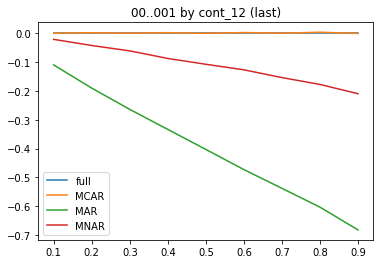

In [5]:
test1_by12 = ivanovo_test(param = 'cont_12', num = 11, varss = np.arange(0, 11, 1))
test1_by12.plot(title = "00..001 by cont_12 (last)")

Потеря по MAR зависит только от 'cont_12', поэтому среднее по переменной 'cont_12' станет меньше относительно исходного. График движется вниз, тк по оси x отложен prop!!, не cor. => очевидно и правильно, что bias растет при увеличении количеcтва потерянных данных.

Кривая MNAR находится выше MAR, тк вклад в wss вносят сразу все 0,1,..,9,10 переменные, а выбиваем в итоге строки с наибольшими суммами. Слишком от многих переменных зависимость.

one variable without mis values: cont_12 [11], analysis by [10]  

In [6]:
%%time
test1_by11 = ivanovo_test(param = 'cont_11', num = 10, varss = np.arange(0, 11, 1))
test1_by10 = ivanovo_test(param = 'cont_10', num = 9, varss = np.arange(0, 11, 1))
test1_by9 = ivanovo_test(param = 'cont_9', num = 8, varss = np.arange(0, 11, 1))
test1_by8 = ivanovo_test(param = 'cont_8', num = 7, varss = np.arange(0, 11, 1))

CPU times: user 2min 51s, sys: 6min 49s, total: 9min 40s
Wall time: 1min 40s


In [7]:
test1_by3 = ivanovo_test(param = 'cont_3', num = 2, varss = np.arange(0, 11, 1))

In [1]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(6 * 3,3 * 3))
# [ax.set_ylim([-0.7, 0.025]) for ax in axes.flatten()]

test1_by12.plot(ax = axes[0,0],title = "00..001 by [11]")
test1_by11.plot(ax = axes[0,1], title = "00..001 by [10]")
test1_by10.plot(ax = axes[0,2], title = "00..001 by [9]")
test1_by9.plot(ax = axes[1,0],title = "00..001 by [8]")
test1_by8.plot(ax = axes[1,1], title = "00..001 by [7]")
test1_by3.plot(ax = axes[1,2], title = "00..001 by [2]")

NameError: name 'plt' is not defined

Все объясняется корреляцией параметров cont_12 c cont_11, cont_10...

In [51]:
corr = df_cont.corr()
corr.style.background_gradient(cmap='coolwarm')

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,0.382237,0.374438,0.427674,0.389335,0.078027,0.270943,0.036506,0.208591,0.357668,0.227889,-0.012598
1,0.382237,1.000000,0.819511,0.463341,0.422108,0.141224,0.212259,-0.222842,0.286739,0.194579,0.246950,0.302332
2,0.374438,0.819511,1.000000,0.493035,0.462493,0.149331,0.188395,-0.333780,0.366164,0.193523,0.284792,0.430566
3,0.427674,0.463341,0.493035,1.000000,0.802498,0.222252,0.238637,-0.120724,0.263525,0.248213,0.261403,0.226980
4,0.389335,0.422108,0.462493,0.802498,1.000000,0.278096,0.245654,-0.110451,0.258942,0.255937,0.245976,0.233664
5,0.078027,0.141224,0.149331,0.222252,0.278096,1.000000,0.043705,-0.052743,0.112726,0.063626,0.194491,0.028966
6,0.270943,0.212259,0.188395,0.238637,0.245654,0.043705,1.000000,0.031232,0.195923,0.797611,0.100046,0.104120
7,0.036506,-0.222842,-0.333780,-0.120724,-0.110451,-0.052743,0.031232,1.000000,-0.336466,0.223300,-0.142416,-0.327886
8,0.208591,0.286739,0.366164,0.263525,0.258942,0.112726,0.195923,-0.336466,1.000000,0.405077,0.309465,0.309841
9,0.357668,0.194579,0.193523,0.248213,0.255937,0.063626,0.797611,0.223300,0.405077,1.000000,0.140621,0.107027


## (000010000000)

Меняем паттерн потери: стб. no.4 lost [ 0,1,2,3,  5,6,7,8,9,10,11]  

In [52]:
test2_by4 = ivanovo_test(param = 'cont_5', num = 4, varss = [ 0,1,2,3,  5,6,7,8,9,10,11])
test2_by11 = ivanovo_test(param = 'cont_12', num = 11, varss = [ 0,1,2,3,  5,6,7,8,9,10,11])
test2_by10 = ivanovo_test(param = 'cont_11', num = 10, varss = [ 0,1,2,3,  5,6,7,8,9,10,11])

In [53]:
test2_by9 = ivanovo_test(param = 'cont_10', num = 9, varss = [ 0,1,2,3,  5,6,7,8,9,10,11])
test2_by8 = ivanovo_test(param = 'cont_9', num = 8, varss = [ 0,1,2,3,  5,6,7,8,9,10,11])
test2_by7 = ivanovo_test(param = 'cont_8', num = 7, varss = [ 0,1,2,3,  5,6,7,8,9,10,11])

<AxesSubplot:title={'center':'000010.. by [7]'}>

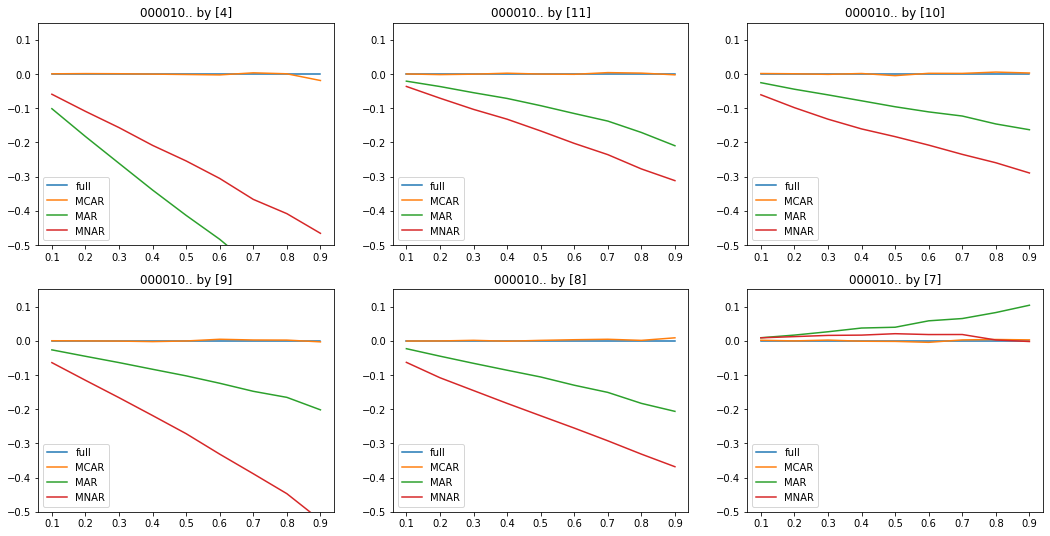

In [54]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize=(6 * 3,3 * 3))
[ax.set_ylim([-0.5, 0.15]) for ax in axes.flatten()]

test2_by4.plot(ax = axes[0,0], title = "000010.. by [4]")
test2_by11.plot(ax = axes[0,1],title = "000010.. by [11]")
test2_by10.plot(ax = axes[0,2], title = "000010.. by [10]")
test2_by9.plot(ax = axes[1,0], title = "000010.. by [9]")
test2_by8.plot(ax = axes[1,1],title = "000010.. by [8]")
test2_by7.plot(ax = axes[1,2], title = "000010.. by [7]")

In [56]:
corr = df_cont.corr()
corr.style.background_gradient(cmap='coolwarm')

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,0.382237,0.374438,0.427674,0.389335,0.078027,0.270943,0.036506,0.208591,0.357668,0.227889,-0.012598
1,0.382237,1.000000,0.819511,0.463341,0.422108,0.141224,0.212259,-0.222842,0.286739,0.194579,0.246950,0.302332
2,0.374438,0.819511,1.000000,0.493035,0.462493,0.149331,0.188395,-0.333780,0.366164,0.193523,0.284792,0.430566
3,0.427674,0.463341,0.493035,1.000000,0.802498,0.222252,0.238637,-0.120724,0.263525,0.248213,0.261403,0.226980
4,0.389335,0.422108,0.462493,0.802498,1.000000,0.278096,0.245654,-0.110451,0.258942,0.255937,0.245976,0.233664
5,0.078027,0.141224,0.149331,0.222252,0.278096,1.000000,0.043705,-0.052743,0.112726,0.063626,0.194491,0.028966
6,0.270943,0.212259,0.188395,0.238637,0.245654,0.043705,1.000000,0.031232,0.195923,0.797611,0.100046,0.104120
7,0.036506,-0.222842,-0.333780,-0.120724,-0.110451,-0.052743,0.031232,1.000000,-0.336466,0.223300,-0.142416,-0.327886
8,0.208591,0.286739,0.366164,0.263525,0.258942,0.112726,0.195923,-0.336466,1.000000,0.405077,0.309465,0.309841
9,0.357668,0.194579,0.193523,0.248213,0.255937,0.063626,0.797611,0.223300,0.405077,1.000000,0.140621,0.107027
